In [172]:
import os
import math
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from torch import nn
import sys
%cd /Users/wenxindong/Desktop/Stanford/CS329P/project/riiid-test-answer-prediction
# %cd /Users/peterchatain/Documents/Classes/CS329P/project/riiid-test-answer-prediction
%ls

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/Users/wenxindong/Desktop/Stanford/CS329P/project/riiid-test-answer-prediction
AutogluonModels/                       cv1_valid.pickle.zip
cv1_train.pickle                       cv1_valid_100k.pickle
cv1_train.pickle.zip                   example_sample_submission.csv
cv1_train_10000k.pickle                example_test.csv
cv1_train_10000k_preprocessed.pickle   lectures.csv
cv1_train_1000k.pickle                 questions.csv
cv1_train_1000k_preprocessed.pickle    riiid-test-answer-prediction.zip
cv1_train_100k.pickle                  riiideducation/
cv1_train_100k_preprocessed.pickle     test_4920_users.pickle
cv1_train_preprocessed.pickle          test_4920_users_preprocessed.pickle
cv1_val_100k_preprocessed.pickle       train.csv
cv1_val_10k.pickle                     train_39360_users.pickle
cv1_val_10k_preprocessed.pickle        train_39360_users_preprocessed.pickle
cv1_val_preprocessed.pickle            valid_4920_users.pickle
cv1_valid.pickle                       valid_4920_use

In [221]:
train_path = "train_39360_users.pickle"
valid_path = "valid_4920_users.pickle"
test_path = "test_4920_users.pickle"
question_path = "questions.csv"
lecture_path = "lectures.csv"
train = pd.read_pickle(train_path)
valid = pd.read_pickle(valid_path)
test = pd.read_pickle(test_path)
questions =  pd.read_csv(question_path)
lectures =  pd.read_csv(lecture_path)

def clean_df(train, is_valid = False, train_mean = 0, train_std = 0):
  print(f"there are {len(train)} raw examples")
  train = train.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
  train = train.drop(np.where(train['content_type_id'] == 1)[0], axis=0).reset_index(drop=True)
  print(f"after dropping lectures, there are {len(train)} examples")
  train['part'] = np.array(questions['part'])[np.array(train['content_id'])]
  train = pd.concat([train, pd.get_dummies(train.part, prefix='part')], axis = 1)
  train = train.drop(["row_id", "task_container_id", "part"], axis=1)
  normalize_cols = ["prior_question_elapsed_time"]
  if not is_valid:
    train_mean = train[normalize_cols].mean()
    train_std = train[normalize_cols].std()
  train[normalize_cols] = (train[normalize_cols] - train_mean) / train_std
  train = train.fillna(0)
  return train, train_mean, train_std
train, train_mean, train_std = clean_df(train)
valid ,_, _ = clean_df(valid, is_valid = True, train_mean = train_mean, train_std = train_std)
test ,_, _ = clean_df(test, is_valid = True, train_mean = train_mean, train_std = train_std)


there are 10091411 raw examples
after dropping lectures, there are 9897114 examples
there are 1293123 raw examples
after dropping lectures, there are 1267253 examples
there are 1214915 raw examples
after dropping lectures, there are 1191168 examples


In [222]:
def add_prior_answered_correctly(train):
    
    mapmap_train = np.unique(train["user_id"], return_counts = True)[1]
    mu = np.mean(train['answered_correctly'])
    sigma = np.std(train['answered_correctly'])
    train['prior_answered_correctly'] = (train['answered_correctly'] - mu) / sigma

    temp = np.append(0, train['prior_answered_correctly'][0:-1])
    temp[np.cumsum(mapmap_train)[:-1]] = 0
    train['prior_answered_correctly']= temp
    train['prior_answered_correctly'] = (train['prior_answered_correctly']>0) + 0
    print(f"mu = {mu}, sigma = {sigma}")

    return train

train = add_prior_answered_correctly(train)
valid = add_prior_answered_correctly(valid)
test = add_prior_answered_correctly(test)

mu = 0.6583242347213542, sigma = 0.47427147995625624
mu = 0.6581132575736652, sigma = 0.4743418575030502
mu = 0.6543661347517731, sigma = 0.4755744909494174


In [223]:
train

,timestamp,user_id,content_id,content_type_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part_1,part_2,part_3,part_4,part_5,part_6,part_7,prior_answered_correctly
0,0,251201,7900,0,2,0,0.000000,0,1,0,0,0,0,0,0,0
1,24821,251201,7876,0,2,0,0.180105,False,1,0,0,0,0,0,0,0
2,48790,251201,175,0,0,0,-0.168350,False,1,0,0,0,0,0,0,0
3,69151,251201,1278,0,1,0,-0.168350,False,0,1,0,0,0,0,0,0
4,176087,251201,2063,0,3,0,-0.367467,False,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897109,553295,2147406199,6880,0,1,0,-0.815481,False,0,0,0,0,0,1,0,0
9897110,638029,2147406199,7218,0,2,1,0.852126,False,0,0,0,0,0,0,1,0
9897111,638029,2147406199,7216,0,0,0,0.852126,False,0,0,0,0,0,0,1,1
9897112,638029,2147406199,7217,0,0,0,0.852126,False,0,0,0,0,0,0,1,0


In [224]:
print("train", train.shape)
print("valid", valid.shape)
print("test ", test.shape)

train (9897114, 16)
valid (1267253, 16)
test  (1191168, 16)


In [225]:
from tqdm import tqdm

WINDOW_LENGTH = 256
FEATURE_DIM = train.shape[1]

def add_window_padding(train):
    train_padded = list()
    loss_mask = list()
    mapmap = np.unique(train['user_id'], return_counts=True)[1]
    lower = np.cumsum(mapmap)
    start = 0
    for l, m in tqdm(zip(lower, mapmap)):
        someee = (((l-start-1)//WINDOW_LENGTH)+1)*WINDOW_LENGTH
        end_index = start + someee
        padded = end_index - l
        temp = np.zeros((1, someee, FEATURE_DIM))
        mask = np.zeros((1, someee))
        temp[:,:l-start] = np.array(train.iloc[start:l], dtype = np.float)
        mask[:, :l-start] =1
        temp = np.reshape(temp, (-1,WINDOW_LENGTH,FEATURE_DIM))
        mask = np.reshape(mask, (-1, WINDOW_LENGTH))
        #Append
        train_padded.append(temp)
        loss_mask.append(mask)
        #Update start
        start = l
    train_padded = np.vstack(train_padded)
    train_padded = torch.from_numpy(train_padded).to(device)
    loss_mask = np.vstack(loss_mask)
    loss_mask = torch.from_numpy(loss_mask).to(device)
    return train_padded, mapmap, loss_mask

train_padded, mapmap_train, loss_mask_train = add_window_padding(train)
valid_padded, mapmap_valid, loss_mask_valid= add_window_padding(valid)
test_padded, mapmap_test, loss_mask_test= add_window_padding(test)

39360it [00:39, 1008.39it/s]
4920it [00:02, 2106.56it/s]
4920it [00:02, 2223.26it/s]


In [226]:
label_idx = list(train.columns).index("answered_correctly")
t_train_y =train_padded[:,:,label_idx:label_idx+1] > 0 
t_train_x = train_padded[:,:,label_idx+1:]
print(t_train_y.shape)
print(t_train_x.shape)
print(loss_mask_train.shape)

t_valid_y =valid_padded[:,:,label_idx:label_idx+1] > 0
t_valid_x = valid_padded[:,:,label_idx+1:]
print(t_valid_y.shape)
print(t_valid_x.shape)
print(loss_mask_valid.shape)

t_test_y =test_padded[:,:,label_idx:label_idx+1] > 0
t_test_x = test_padded[:,:,label_idx+1:]
print(t_test_y.shape)
print(t_test_x.shape)
print(loss_mask_test.shape)

torch.Size([67639, 256, 1])
torch.Size([67639, 256, 10])
torch.Size([67639, 256])
torch.Size([8580, 256, 1])
torch.Size([8580, 256, 10])
torch.Size([8580, 256])
torch.Size([8287, 256, 1])
torch.Size([8287, 256, 10])
torch.Size([8287, 256])


In [227]:
batch_size = 16

def batchify(t_train_x, t_train_y, loss_mask_train, batch_size):
  
  total = (t_train_y.shape[0]//batch_size-1)*batch_size
  t_train_y = t_train_y[:total]
  t_train_x = t_train_x[:total, :, :] 
  loss_mask_train = loss_mask_train[:total,:]
  num_batches = int(t_train_y.shape[0] / batch_size)
  t_train_x = t_train_x.reshape(num_batches, batch_size, WINDOW_LENGTH, 10)
  t_train_y = t_train_y.reshape(num_batches,batch_size, -1)
  loss_mask_train = loss_mask_train.reshape(num_batches, batch_size, -1)
  print(t_train_x.shape)
  print(t_train_y.shape)
  print(loss_mask_train.shape)
  return t_train_x, t_train_y, loss_mask_train
t_train_x, t_train_y , loss_mask_train=  batchify(t_train_x, t_train_y, loss_mask_train, batch_size)
t_valid_x, t_valid_y , loss_mask_valid=  batchify(t_valid_x, t_valid_y, loss_mask_valid,batch_size)
t_test_x, t_test_y , loss_mask_test=  batchify(t_test_x, t_test_y, loss_mask_test,batch_size)

torch.Size([4226, 16, 256, 10])
torch.Size([4226, 16, 256])
torch.Size([4226, 16, 256])
torch.Size([535, 16, 256, 10])
torch.Size([535, 16, 256])
torch.Size([535, 16, 256])
torch.Size([516, 16, 256, 10])
torch.Size([516, 16, 256])
torch.Size([516, 16, 256])


In [228]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int = 9, dropout: float = 0.1, max_len: int = 512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x.permute(1, 0, 2) + self.pe[:x.size(1)]
        x = x.permute(1, 0, 2)
        return self.dropout(x)


In [229]:
class TransformerModel(torch.nn.Module):
    def __init__(self, n_encoder_layers=3, d_model=9, n_heads=3, dropout = 0.1):
        super(TransformerModel, self).__init__()
        self.n_encoder_layers = n_encoder_layers
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model)
        self.tranformer_encoder = TransformerModelEncoder(n_encoder_layers, d_model, n_heads,dropout)
        self.decoder = torch.nn.Linear(d_model, 1)
    def forward(self, X):
        X = self.positional_encoding(X)
        out = self.tranformer_encoder(X)
        out = self.decoder(out)
        return out

In [230]:
class TransformerModelEncoder(torch.nn.Module):
    def __init__(self, n_encoder_layers=3, d_model=9, n_heads=3, dropout= 0.1):
        super(TransformerModelEncoder, self).__init__()
        self.encoder = []
        self.n_encoder_layers = n_encoder_layers
        for i in range(n_encoder_layers):
            self.encoder.append(TransformerEncoderLayer(n_heads,d_model, dropout))
    def forward(self, X):
        for i in range(self.n_encoder_layers):
            X = self.encoder[i](X)
        return X

In [231]:
class TransformerEncoderLayer(torch.nn.Module):
    def __init__(self, n_heads=3,d_model=9, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiheadAttention(n_heads,d_model, dropout)
        self.linear = torch.nn.Linear(d_model, d_model)
        self.linear2 = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm = torch.nn.LayerNorm([WINDOW_LENGTH, d_model])
    def forward(self, X):
        oldX = X
        X = self.attention(X)
        X = self.linear(X) 
        X = self.layer_norm(self.dropout(X) + oldX)
        return X

In [232]:
class MultiheadAttention(torch.nn.Module):
    #Note that d_model should be divisible by the number of heads (n_heads)
    def __init__(self, n_heads=3, d_model=9, dropout=0.1):
        super(MultiheadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dropout = dropout
        self.small_d = d_model//n_heads
        
        self.Q = torch.nn.Linear(d_model, d_model)
        self.K = torch.nn.Linear(d_model, d_model)
        self.V = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm([WINDOW_LENGTH, d_model])
    #Note that X is input with the size (# of strings, Max Length of strings, #features of string)
    def forward(self, X):
        q_X = self.Q(X)
        k_X =  self.K(X)
        v_X =  self.V(X)
        max_len = X.shape[1]
        batch_size = X.shape[0]
        q_X_h = q_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0,2,1,3)
        k_X_h = k_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0,2,3,1)
        v_X_h = v_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0, 2, 1, 3)
        mask = torch.triu(torch.ones(max_len,max_len)*float('-inf'), diagonal=1)
        score = torch.softmax((q_X_h @ k_X_h)/np.sqrt(self.small_d) + mask, axis = -1)
                
        result = (score@v_X_h).permute(0, 2, 1, 3)
        result = result.reshape(batch_size, max_len, self.d_model)
        result = self.layer_norm(X + self.dropout(result))
        return result

In [233]:
# Q = torch.randn((9, 15))
# K = torch.randn((9, 15))
# V = torch.randn((9, 15))
# small_d = 5
# n_heads = 3

# X = t_train_x[0]

# Train LSTM

100%|██████████| 4226/4226 [00:52<00:00, 80.21it/s]


train


100%|██████████| 100/100 [00:00<00:00, 217.37it/s]


evaluation of  has acc: 0.671792613100107, loss: 0.0002637803473270974, auc: 0.6834992690553633
valid


100%|██████████| 100/100 [00:00<00:00, 215.41it/s]


evaluation of  has acc: 0.6784826190598686, loss: 0.00026890946935206265, auc: 0.6836191823136817


100%|██████████| 4226/4226 [00:52<00:00, 80.81it/s]


train


100%|██████████| 100/100 [00:00<00:00, 221.94it/s]


evaluation of  has acc: 0.6717758342247111, loss: 0.00026360834210614493, auc: 0.6399593815193846
valid


100%|██████████| 100/100 [00:00<00:00, 188.25it/s]


evaluation of  has acc: 0.6785512167515563, loss: 0.000268774294355558, auc: 0.6401754109426082


100%|██████████| 4226/4226 [00:54<00:00, 77.89it/s]


train


100%|██████████| 100/100 [00:00<00:00, 219.55it/s]


evaluation of  has acc: 0.6719939596048575, loss: 0.00026352124594606886, auc: 0.6701030996593255
valid


100%|██████████| 100/100 [00:00<00:00, 220.74it/s]


evaluation of  has acc: 0.6788384695854984, loss: 0.0002686854121543827, auc: 0.6696411714398867


100%|██████████| 4226/4226 [00:53<00:00, 79.33it/s]


train


100%|██████████| 100/100 [00:00<00:00, 221.63it/s]


evaluation of  has acc: 0.6722624216111915, loss: 0.00026344303969851014, auc: 0.675630551375891
valid


100%|██████████| 100/100 [00:00<00:00, 221.42it/s]


evaluation of  has acc: 0.6787055615578536, loss: 0.00026863454221990934, auc: 0.6748003211594034


100%|██████████| 4226/4226 [00:53<00:00, 79.42it/s]


train


100%|██████████| 100/100 [00:00<00:00, 216.10it/s]


evaluation of  has acc: 0.6724260156463013, loss: 0.00026338843959351586, auc: 0.6508781145516314
valid


100%|██████████| 100/100 [00:00<00:00, 221.34it/s]


evaluation of  has acc: 0.678842756941229, loss: 0.0002686113641607948, auc: 0.64903339945962


100%|██████████| 4226/4226 [00:52<00:00, 80.21it/s]


train


100%|██████████| 100/100 [00:00<00:00, 222.85it/s]


evaluation of  has acc: 0.6724302103651503, loss: 0.0002633699653691894, auc: 0.6206043044911655
valid


100%|██████████| 100/100 [00:00<00:00, 196.02it/s]


evaluation of  has acc: 0.6789542281902214, loss: 0.00026860264539348903, auc: 0.6183126019659939


100%|██████████| 4226/4226 [00:51<00:00, 81.44it/s]


train


100%|██████████| 100/100 [00:00<00:00, 222.77it/s]


evaluation of  has acc: 0.6725644413683173, loss: 0.00026335792010662574, auc: 0.5836510463719348
valid


100%|██████████| 100/100 [00:00<00:00, 219.65it/s]


evaluation of  has acc: 0.6790571247277529, loss: 0.0002685985213418395, auc: 0.5810970114063762


100%|██████████| 4226/4226 [00:52<00:00, 80.76it/s]


train


100%|██████████| 100/100 [00:00<00:00, 226.63it/s]


evaluation of  has acc: 0.672606388556807, loss: 0.00026333332966788466, auc: 0.5561438268549204
valid


100%|██████████| 100/100 [00:00<00:00, 223.93it/s]


evaluation of  has acc: 0.6789113546329166, loss: 0.00026860099282269214, auc: 0.5535613966325064


100%|██████████| 4226/4226 [00:52<00:00, 81.04it/s]


train


100%|██████████| 100/100 [00:00<00:00, 221.09it/s]


evaluation of  has acc: 0.6726986723714843, loss: 0.00026331884984201, auc: 0.5204016674403528
valid


100%|██████████| 100/100 [00:00<00:00, 219.61it/s]


evaluation of  has acc: 0.6790957109293272, loss: 0.0002685835109325691, auc: 0.5181622094451429


100%|██████████| 4226/4226 [00:54<00:00, 78.07it/s]


train


100%|██████████| 100/100 [00:00<00:00, 226.04it/s]


evaluation of  has acc: 0.6726105832756559, loss: 0.00026332110896761397, auc: 0.5054950037364662
valid


100%|██████████| 100/100 [00:00<00:00, 225.81it/s]


evaluation of  has acc: 0.6792114695340502, loss: 0.00026857200573245153, auc: 0.5032616083167939


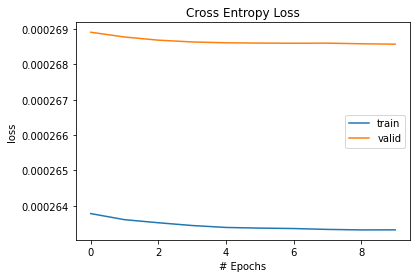

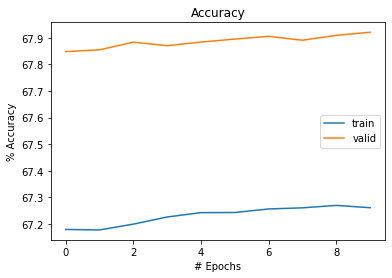

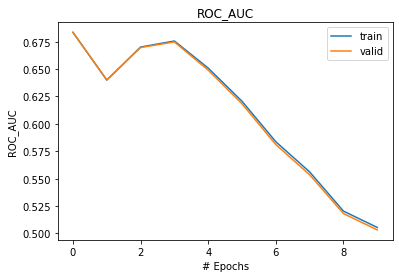

In [234]:
all_preds = []
all_preds2 = []
def evaluate_rnn(transformer_model, t_valid_x, t_valid_y, loss_mask_valid, name_data = ""):
    transformer_model.eval()
    out_all=[]
    tgt_all=[]
    with torch.no_grad():
      acc = 0
      count = 0
      acc_total = 0
      loss_total = 0
      num_batches = t_valid_x.shape[0]
      num_batches =100
      for batch in tqdm(range(num_batches)):
          src = t_valid_x[batch,:,:,:].to(device).float()
          tgt = t_valid_y[batch] + 0
          loss_mask_batch = loss_mask_valid[batch, :, :]
          out, _ = transformer_model(src)
          out = torch.sigmoid(out[:,:, [0]]).squeeze(-1)
          out_all.append(out.cpu().numpy()[:int(torch.sum(loss_mask_batch))])
          tgt_all.append(tgt.cpu().numpy()[:int(torch.sum(loss_mask_batch))])
          
          prediction = out>0.5
          all_preds.append(prediction)

          acc = torch.sum((tgt== prediction) *(loss_mask_batch))
          loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
          loss_total += loss
          acc_total += acc
          count+= torch.sum(loss_mask_batch)
      out_all = np.concatenate(out_all, axis=None)
      tgt_all = np.concatenate(tgt_all, axis=None)
      roc_auc_score_total = roc_auc_score(tgt_all, out_all)
      print("evaluation of {} has acc: {}, loss: {}, auc: {}".format(name_data, acc_total/count, loss_total / count, roc_auc_score_total))
    return acc_total/count, loss_total / count, roc_auc_score_total, out_all, tgt_all

num_batches = t_train_x.shape[0]
lstm_model = torch.nn.LSTM(10, 10, 2)
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
num_epochs = 10
total_loss = 0
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
train_roc_aucs = []
valid_roc_aucs = []
lstm_model.train()
for epoch in range(num_epochs):
    for batch in tqdm(range(num_batches)):
      optim.zero_grad()
      src = t_train_x[batch,:,:,:].to(device).float()
      tgt = t_train_y[batch] + 0
      loss_mask_batch = loss_mask_train[batch, :, :]
      
      class_weight = loss_mask_batch - tgt*(1 - 0.4/0.6)
      out, _ = lstm_model(src)
      out = torch.sigmoid(out[:, :, 0]).squeeze(-1)
      prediction = out>0.5
      all_preds_count = 0
      true_pred = 0
      acc = torch.sum((tgt== prediction) *(loss_mask_batch)) /torch.sum(loss_mask_batch)
      plot_acc.append(acc)
      loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
      loss.backward()
      optim.step()
      total_loss += loss.item()
    print("train")
    train_acc, train_loss, train_roc_auc,_,_ = evaluate_rnn(lstm_model, t_train_x,  t_train_y, loss_mask_train)
    print("valid")
    valid_acc, valid_loss, valid_roc_auc,_,_ = evaluate_rnn(lstm_model, t_valid_x,  t_valid_y, loss_mask_valid)
    train_losses.append(train_loss.item()), train_accs.append(train_acc*100), train_roc_aucs.append(train_roc_auc)
    valid_losses.append(valid_loss), valid_accs.append(valid_acc*100), valid_roc_aucs.append(valid_roc_auc)

plt.plot(train_losses, label = "train")
plt.plot(valid_losses, label = "valid")
plt.title('Cross Entropy Loss')
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(train_accs,  label = "train")
plt.plot(valid_accs,  label = "valid")
plt.title('Accuracy')
plt.xlabel('# Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()
plt.plot(train_roc_aucs,  label = "train")
plt.plot(valid_roc_aucs,  label = "valid")
plt.title('ROC_AUC')
plt.xlabel('# Epochs')
plt.ylabel('ROC_AUC')
plt.legend()
plt.show()


In [235]:
valid_acc, valid_loss, valid_roc_auc, pred_proba ,target  = evaluate_rnn(lstm_model,t_test_x, t_test_y, loss_mask_test)

100%|██████████| 100/100 [00:00<00:00, 216.81it/s]


evaluation of  has acc: 0.670643277857681, loss: 0.0002695343157533957, auc: 0.49498771416974296


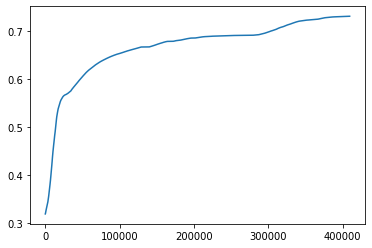

In [236]:
plt.plot(sorted(pred_proba))

In [237]:
target

array([1, 0, 0, ..., 0, 0, 0])

# Train transfomer

In [239]:
def evaluate(transformer_model,t_valid_x, t_valid_y , loss_mask_valid, name_data = ""):
    transformer_model.eval()
    with torch.no_grad():
      acc = 0
      count = 0
      acc_total = 0
      loss_total = 0
      out_all = []
      tgt_all =[]
      num_batches = t_valid_x.shape[0]
      num_batches = 100
      for batch in range(num_batches):

          src = t_valid_x[batch,:,:,:].to(device).float()
          tgt = t_valid_y[batch] + 0
          loss_mask_batch = loss_mask_valid[batch, :, :]
          out = transformer_model(src)
          out = torch.sigmoid(out).squeeze(-1)
          out_all.append(out.cpu().numpy()[:int(torch.sum(loss_mask_batch))])
          tgt_all.append(tgt.cpu().numpy()[:int(torch.sum(loss_mask_batch))])
          prediction = out>0.5
          acc = torch.sum((tgt== prediction) *(loss_mask_batch))
          loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
          loss_total += loss
          acc_total += acc
          count+= torch.sum(loss_mask_batch)
      out_all = np.concatenate(out_all, axis = None)
      tgt_all = np.concatenate(tgt_all, axis = None)
      roc_auc_total = roc_auc_score(tgt_all, out_all)
      print("evaluation acc of {}: {}, loss: {}, auc: {}".format(name_data, acc_total/count, loss_total / count, roc_auc_total))
    return acc_total/count, loss_total / count, roc_auc_total, out_all, tgt_all


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_batches = t_train_x.shape[0]
transformer_model = TransformerModel(d_model = 10, n_heads=2, n_encoder_layers=3, dropout = 0.1)
optim = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
transformer_model.train()
num_batches = t_train_x.shape[0]
num_epochs = 8
log_interval = 10
total_loss = 0
plot_loss= []
plot_acc= []
# plot_roc_aucs = []
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
train_roc_aucs = []
valid_roc_aucs = []
for epoch in range(num_epochs):
    for batch in tqdm(range(num_batches)):
      optim.zero_grad()
      src = t_train_x[batch,:,:,:].to(device).float()
      tgt = t_train_y[batch] + 0
      loss_mask_batch = loss_mask_train[batch, :, :]
      class_weight = loss_mask_batch - tgt*(1 - 0.4/0.6)
      out = transformer_model(src)
      out = torch.sigmoid(out).squeeze(-1)
      prediction = out>0.5
      # plot_roc_aucs.append(roc_auc_score(out, tgt)) # I guess I can't use numpy in here since there's no gradient?
      acc = torch.sum((tgt== prediction) *(loss_mask_batch)) /torch.sum(loss_mask_batch)
      plot_acc.append(acc)
      loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch*class_weight)/torch.sum(loss_mask_batch)
      loss.backward()
      optim.step()
    train_acc, train_loss, train_auc, _, _ = evaluate(transformer_model, t_train_x,  t_train_y, loss_mask_train, "train")
    valid_acc, valid_loss, valid_auc, _, _ = evaluate(transformer_model, t_valid_x,  t_valid_y, loss_mask_valid, "valid")
    train_losses.append(train_loss.item())
    train_accs.append(train_acc*100) 
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc*100)
    train_roc_aucs.append(train_auc)
    valid_roc_aucs.append(valid_auc)
print(f"We finnished training with {num_epochs} epochs")

cpu


100%|██████████| 4226/4226 [05:04<00:00, 13.89it/s]


evaluation acc of train: 0.6528115103085216, loss: 0.00027672404460968303, auc: 0.61118164065278
evaluation acc of valid: 0.657963334533793, loss: 0.00028285806102863205, auc: 0.6087551836972077


100%|██████████| 4226/4226 [05:05<00:00, 13.84it/s]


evaluation acc of train: 0.6467459468529122, loss: 0.0002766596794901462, auc: 0.6152732000116583
evaluation acc of valid: 0.6523640479497865, loss: 0.00028263699155986276, auc: 0.6150771066237544


100%|██████████| 4226/4226 [04:59<00:00, 14.09it/s]


evaluation acc of train: 0.6469766563896054, loss: 0.0002766414402066412, auc: 0.6144592388316307
evaluation acc of valid: 0.6512964963728971, loss: 0.0002827133195746483, auc: 0.6137874518897266


100%|██████████| 4226/4226 [04:55<00:00, 14.32it/s]


evaluation acc of train: 0.646372616875354, loss: 0.0002767572626198631, auc: 0.6140543293646846
evaluation acc of valid: 0.6510735538749121, loss: 0.00028267975571219967, auc: 0.6133882692409808


100%|██████████| 4226/4226 [09:52<00:00,  7.13it/s]   


evaluation acc of train: 0.6450890329075694, loss: 0.0002767846929916048, auc: 0.6122224473695832
evaluation acc of valid: 0.6510864159421036, loss: 0.00028273357050292807, auc: 0.6131675046663982


100%|██████████| 4226/4226 [04:53<00:00, 14.39it/s]


evaluation acc of train: 0.6462761383418276, loss: 0.00027671085219331906, auc: 0.6128193305786632
evaluation acc of valid: 0.6506834045034384, loss: 0.00028281191882374024, auc: 0.6127053861969879


100%|██████████| 4226/4226 [04:54<00:00, 14.33it/s]


evaluation acc of train: 0.6462761383418276, loss: 0.00027658184956719207, auc: 0.6142042820903583
evaluation acc of valid: 0.6510306803176074, loss: 0.0002825636715569816, auc: 0.6136825776109126


100%|██████████| 4226/4226 [05:01<00:00, 14.02it/s]


evaluation acc of train: 0.6462887224983745, loss: 0.00027671883455622644, auc: 0.6128678402587087
evaluation acc of valid: 0.6509706573373806, loss: 0.00028276244513365974, auc: 0.612857939697066
We finnished training with 8 epochs


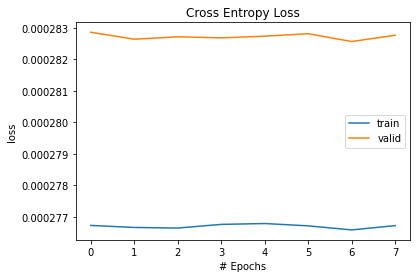

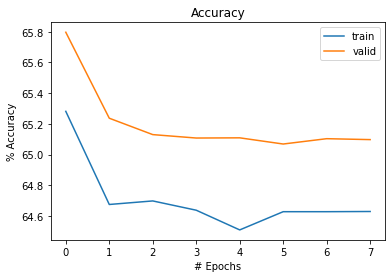

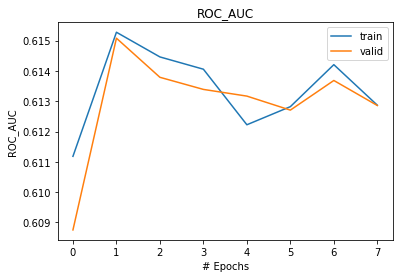

In [240]:
plt.plot(train_losses, label = "train")
plt.plot(valid_losses, label = "valid")
plt.title('Cross Entropy Loss')
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(train_accs,  label = "train")
plt.plot(valid_accs,  label = "valid")
plt.title('Accuracy')
plt.xlabel('# Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()
plt.plot(train_roc_aucs,  label = "train")
plt.plot(valid_roc_aucs,  label = "valid")
plt.title('ROC_AUC')
plt.xlabel('# Epochs')
plt.ylabel('ROC_AUC')
plt.legend()
plt.show()